In [1]:
#pip install keras

In [2]:
#pip install tensorflow

In [3]:
import sklearn
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

### Считываем данные

In [38]:
#train data
df_train = pd.read_csv("train_data.csv")
df_train.head()

,Unnamed: 0,sentence,label
0,0,Срыв сроков строительства зоопарка оценили в 1...,1
1,1,"По данным Генпрокуратуры РФ, в 2014-2018 годах...",1
2,2,"Обвиняли в этом столичный акимат, который сорв...",1
3,3,Запуск циклотронного центра ядерной медицины н...,1
4,4,Сроки сдачи объекта несколько раз переносились.,1


In [39]:
df_train = df_train.rename(columns={"Unnamed: 0": "id"})

###  Очищаем данные от лишних символов и переводим все слова в строчный формат

In [40]:
# clean up data
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\_\n]", " ",regex=False)
    df[text_field] = df[text_field].str.lower()
    return df


In [41]:
clean_df_train = standardize_text(df_train, "sentence")

clean_df_train.head()

,id,sentence,label
0,0,срыв сроков строительства зоопарка оценили в 1...,1
1,1,"по данным генпрокуратуры рф, в 2014-2018 годах...",1
2,2,"обвиняли в этом столичный акимат, который сорв...",1
3,3,запуск циклотронного центра ядерной медицины н...,1
4,4,сроки сдачи объекта несколько раз переносились.,1


### Токенизируем  данные

In [42]:
#tokenizing sentences to a list of separate words

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_df_train["tokens"] = clean_df_train["sentence"].apply(tokenizer.tokenize)
clean_df_train.head()

,id,sentence,label,tokens
0,0,срыв сроков строительства зоопарка оценили в 1...,1,"[срыв, сроков, строительства, зоопарка, оценил..."
1,1,"по данным генпрокуратуры рф, в 2014-2018 годах...",1,"[по, данным, генпрокуратуры, рф, в, 2014, 2018..."
2,2,"обвиняли в этом столичный акимат, который сорв...",1,"[обвиняли, в, этом, столичный, акимат, который..."
3,3,запуск циклотронного центра ядерной медицины н...,1,"[запуск, циклотронного, центра, ядерной, медиц..."
4,4,сроки сдачи объекта несколько раз переносились.,1,"[сроки, сдачи, объекта, несколько, раз, перено..."


In [43]:
#nltk.download('stopwords')

### Удаляем стоп слова

In [44]:
from nltk.corpus import stopwords
def lineWithoutStopWords(line):
    return [word for word in line if word not in stopwords.words("russian")]
clean_df_train["tokens"] = [lineWithoutStopWords(line) for line in clean_df_train["tokens"]]
clean_df_train.head()

,id,sentence,label,tokens
0,0,срыв сроков строительства зоопарка оценили в 1...,1,"[срыв, сроков, строительства, зоопарка, оценил..."
1,1,"по данным генпрокуратуры рф, в 2014-2018 годах...",1,"[данным, генпрокуратуры, рф, 2014, 2018, годах..."
2,2,"обвиняли в этом столичный акимат, который сорв...",1,"[обвиняли, столичный, акимат, который, сорвал,..."
3,3,запуск циклотронного центра ядерной медицины н...,1,"[запуск, циклотронного, центра, ядерной, медиц..."
4,4,сроки сдачи объекта несколько раз переносились.,1,"[сроки, сдачи, объекта, несколько, переносились]"


In [ ]:
#pip install pymorphy2

### Лемматизация

In [45]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def normalForm(line):
    return [morph.parse(word)[0].normal_form for word in line if len(word)>2]
clean_df_train["tokens"] = [normalForm(line) for line in clean_df_train["tokens"]]
clean_df_train.head()

,id,sentence,label,tokens
0,0,срыв сроков строительства зоопарка оценили в 1...,1,"[срыв, срок, строительство, зоопарк, оценить, ..."
1,1,"по данным генпрокуратуры рф, в 2014-2018 годах...",1,"[данные, генпрокуратура, 2014, 2018, год, выяв..."
2,2,"обвиняли в этом столичный акимат, который сорв...",1,"[обвинять, столичный, акимат, который, сорвать..."
3,3,запуск циклотронного центра ядерной медицины н...,1,"[запуск, циклотронный, центр, ядерный, медицин..."
4,4,сроки сдачи объекта несколько раз переносились.,1,"[срок, сдача, объект, несколько, переноситься]"


### Подсчитаем количество слов, слов без повторений и длину фраз

In [46]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


all_words = [word for tokens in clean_df_train["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_df_train["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

21670 words total, with a vocabulary size of 4445
Max sentence length is 94


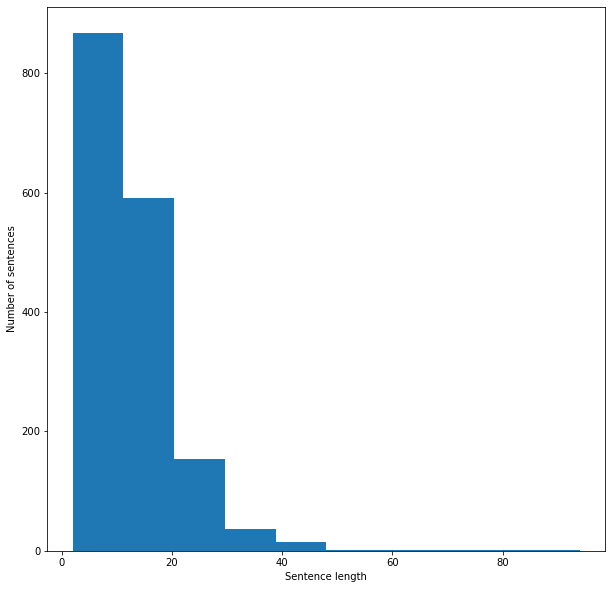

In [47]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [48]:
clean_df_train['tokens'] = (pd.DataFrame(clean_df_train.tokens.tolist())
                      .fillna('')
                      .astype(str)
                      .agg(','.join, 1)
                      .str.strip(','))
clean_df_train.head()

,id,sentence,label,tokens
0,0,срыв сроков строительства зоопарка оценили в 1...,1,"срыв,срок,строительство,зоопарк,оценить,млрд,р..."
1,1,"по данным генпрокуратуры рф, в 2014-2018 годах...",1,"данные,генпрокуратура,2014,2018,год,выявить,ты..."
2,2,"обвиняли в этом столичный акимат, который сорв...",1,"обвинять,столичный,акимат,который,сорвать,срок..."
3,3,запуск циклотронного центра ядерной медицины н...,1,"запуск,циклотронный,центр,ядерный,медицина,баз..."
4,4,сроки сдачи объекта несколько раз переносились.,1,"срок,сдача,объект,несколько,переноситься"


### Считываем тестовый сет, преобразуем его, токенизируем и проводим лемматизацию


In [15]:
df_test = pd.read_csv("test_data.csv")
df_test.head()

,Unnamed: 0,id,title,text
0,0.0,0,Графики обслуживания внутриквартирного и внутр...,В соответствии с п.42 Постановления Правительс...
1,1.0,1,На МЦД улучшили поезда,"В Москве, на Белорусско-Савеловском центрально..."
2,2.0,2,Катастрофа SSJ 100: вина за гибель 41 человека...,Завершено расследование дела о крушении самоле...
3,3.0,3,С Днем юриста!,От души поздравляем сотрудников и преподавател...
4,4.0,4,"Охота на ""черного"" лесоруба","В Костроме прошел межрегиональный форум, посвя..."


In [16]:
df1 = df_test[df_test.isna().any(axis=1)]
df1.head()

,Unnamed: 0,id,title,text
130,130.0,130,NaN,"В США закончился ""золотой век"" добычи сланцево..."
153,153.0,153,NaN,Незыгаревские ребята по этой теме прямо как бу...
156,156.0,156,NaN,Что случилось за ночь. Главные новости РБК\n«Р...
158,158.0,158,NaN,Сенат Конгресса США одобрил в понедельник назн...
174,174.0,174,NaN,"Вполне закономерно, что Сергей Фургал отказалс..."


In [17]:
df_test.fillna('', inplace=True)

In [18]:
df_test['sentence'] = df_test['title'] + ' ' + df_test['text']
df_test.head()

,Unnamed: 0,id,title,text,sentence
0,0.0,0,Графики обслуживания внутриквартирного и внутр...,В соответствии с п.42 Постановления Правительс...,Графики обслуживания внутриквартирного и внутр...
1,1.0,1,На МЦД улучшили поезда,"В Москве, на Белорусско-Савеловском центрально...","На МЦД улучшили поезда В Москве, на Белорусско..."
2,2.0,2,Катастрофа SSJ 100: вина за гибель 41 человека...,Завершено расследование дела о крушении самоле...,Катастрофа SSJ 100: вина за гибель 41 человека...
3,3.0,3,С Днем юриста!,От души поздравляем сотрудников и преподавател...,С Днем юриста! От души поздравляем сотрудников...
4,4.0,4,"Охота на ""черного"" лесоруба","В Костроме прошел межрегиональный форум, посвя...","Охота на ""черного"" лесоруба В Костроме прошел ..."


In [19]:
clean_test = df_test.drop(['title','text','Unnamed: 0'],axis = 1)

clean_test.head()

,id,sentence
0,0,Графики обслуживания внутриквартирного и внутр...
1,1,"На МЦД улучшили поезда В Москве, на Белорусско..."
2,2,Катастрофа SSJ 100: вина за гибель 41 человека...
3,3,С Днем юриста! От души поздравляем сотрудников...
4,4,"Охота на ""черного"" лесоруба В Костроме прошел ..."


In [20]:
clean_test = standardize_text(clean_test,"sentence")
clean_test.head()

,id,sentence
0,0,графики обслуживания внутриквартирного и внутр...
1,1,"на мцд улучшили поезда в москве, на белорусско..."
2,2,катастрофа ssj 100: вина за гибель 41 человека...
3,3,с днем юриста! от души поздравляем сотрудников...
4,4,"охота на ""черного"" лесоруба в костроме прошел ..."


In [21]:
clean_test["tokens"] = clean_test["sentence"].apply(tokenizer.tokenize)
clean_test.head()

,id,sentence,tokens
0,0,графики обслуживания внутриквартирного и внутр...,"[графики, обслуживания, внутриквартирного, и, ..."
1,1,"на мцд улучшили поезда в москве, на белорусско...","[на, мцд, улучшили, поезда, в, москве, на, бел..."
2,2,катастрофа ssj 100: вина за гибель 41 человека...,"[катастрофа, ssj, 100, вина, за, гибель, 41, ч..."
3,3,с днем юриста! от души поздравляем сотрудников...,"[с, днем, юриста, от, души, поздравляем, сотру..."
4,4,"охота на ""черного"" лесоруба в костроме прошел ...","[охота, на, черного, лесоруба, в, костроме, пр..."


In [26]:
clean_test["tokens"] = [lineWithoutStopWords(line) for line in clean_test["tokens"]]

,id,sentence,tokens
0,0,графики обслуживания внутриквартирного и внутр...,"[графики, обслуживания, внутриквартирного, вну..."
1,1,"на мцд улучшили поезда в москве, на белорусско...","[мцд, улучшили, поезда, москве, белорусско, са..."
2,2,катастрофа ssj 100: вина за гибель 41 человека...,"[катастрофа, ssj, 100, вина, гибель, 41, челов..."
3,3,с днем юриста! от души поздравляем сотрудников...,"[днем, юриста, души, поздравляем, сотрудников,..."
4,4,"охота на ""черного"" лесоруба в костроме прошел ...","[охота, черного, лесоруба, костроме, прошел, м..."


In [27]:
clean_test["tokens"] = [normalForm(line) for line in clean_test["tokens"]]

,id,sentence,tokens
0,0,графики обслуживания внутриквартирного и внутр...,"[графика, обслуживание, внутриквартирный, внут..."
1,1,"на мцд улучшили поезда в москве, на белорусско...","[мцд, улучшить, поезд, москва, белорусско, сав..."
2,2,катастрофа ssj 100: вина за гибель 41 человека...,"[катастрофа, ssj, 100, вино, гибель, человек, ..."
3,3,с днем юриста! от души поздравляем сотрудников...,"[день, юрист, душа, поздравлять, сотрудник, пр..."
4,4,"охота на ""черного"" лесоруба в костроме прошел ...","[охота, чёрный, лесоруб, кострома, пройти, меж..."


In [28]:
clean_test['tokens'] = (pd.DataFrame(clean_test.tokens.tolist())
                      .fillna('')
                      .astype(str)
                      .agg(','.join, 1)
                      .str.strip(','))
clean_test.head()

,id,sentence,tokens
0,0,графики обслуживания внутриквартирного и внутр...,"графика,обслуживание,внутриквартирный,внутридо..."
1,1,"на мцд улучшили поезда в москве, на белорусско...","мцд,улучшить,поезд,москва,белорусско,савёловск..."
2,2,катастрофа ssj 100: вина за гибель 41 человека...,"катастрофа,ssj,100,вино,гибель,человек,возложи..."
3,3,с днем юриста! от души поздравляем сотрудников...,"день,юрист,душа,поздравлять,сотрудник,преподав..."
4,4,"охота на ""черного"" лесоруба в костроме прошел ...","охота,чёрный,лесоруб,кострома,пройти,межрегион..."


### В качестве представления данных был выбран "Мешок слов".
##### Каждое предложение  можно  отобразить списком, длина которого равна числу уникальных слов в нашем словаре, а в каждом индексе в этом списке будет храниться, сколько раз данное слово встречается в предложении.

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    
    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

X_train = clean_df_train["tokens"].tolist()
y_train = clean_df_train["label"].tolist()
X_test = clean_test["tokens"].tolist()



X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Используем логистическую регрессию чтобы построить модель для классификации

In [31]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict_proba(X_test_counts)

#### Получаем вероятность принадлежности новости к положительному классу и добавляем ее в датасет

In [32]:
np.set_printoptions(suppress=True)
prob = y_predicted_counts[:,1].round(2)

In [33]:
df_test['prob'] = prob
df_test = df_test.drop(['sentence'],axis = 1)

In [52]:
df_test.to_csv('test_data_result.csv')

In [35]:
df_test.head()

,Unnamed: 0,id,title,text,prob
0,0.0,0,Графики обслуживания внутриквартирного и внутр...,В соответствии с п.42 Постановления Правительс...,0.96
1,1.0,1,На МЦД улучшили поезда,"В Москве, на Белорусско-Савеловском центрально...",0.00
2,2.0,2,Катастрофа SSJ 100: вина за гибель 41 человека...,Завершено расследование дела о крушении самоле...,1.00
3,3.0,3,С Днем юриста!,От души поздравляем сотрудников и преподавател...,0.01
4,4.0,4,"Охота на ""черного"" лесоруба","В Костроме прошел межрегиональный форум, посвя...",1.00


### Значимость слов используемых для прогноза

In [36]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

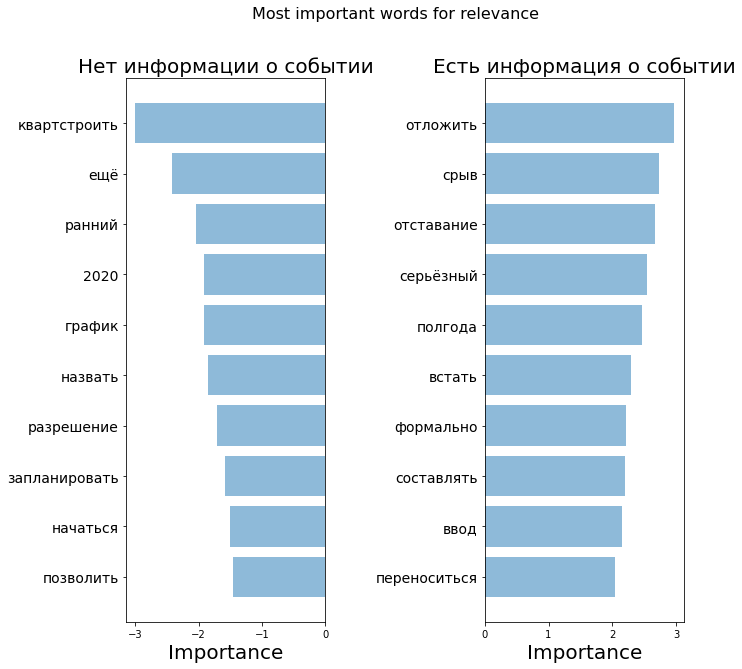

In [37]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Нет информации о событии', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Есть информация о событии', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")